# Overview

In this notebook, I am going to use Efficient Net b0, along with some improvements over previous baseline attempt, such as- use of weighted loss for back propagation so that it can address imbalanced dataset better, and a few additional layers on top of the base model.

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
312,2158,0540000022438.jpg,Silk,Saree,"black,blue,cyan,green","embroidery,nakshi",nakshi
2814,7496,0410000108357.jpg,Cotton,Skirts,"grey,red",embroidery,NaN
2279,7399,0410000101240.jpg,Viscose Blend,Tops,"red,brown,black,pink",screen print,NaN


In [4]:
single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']

Repeating the preprcessing steps to remove NaN values and removing rare labels (details explained in previous notebook)

In [5]:
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
3156,7779,0470000103249.jpg,Silk,Scarves,"red,white,green",hand paint,
2766,3486,0660000104783_1.jpg,Viscose,Shawls,"black,green",,"handloom,fringe"
1527,8005,0460000028737.jpg,Voile,Nightwear,"black,white,green","embroidery,printed",


Encode the labels as done previously

In [6]:
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean,fabric_types_clean__Cotton,fabric_types_clean__Linen,fabric_types_clean__Muslin,...,textures_clean__wax dye,value_additions_clean__,value_additions_clean__applique,value_additions_clean__fringe,value_additions_clean__handloom,value_additions_clean__lace,value_additions_clean__nakshi,value_additions_clean__sequins,value_additions_clean__tangail,value_additions_clean__tassels
3010,6279,1190000012465_1.jpg,Viscose,Kurta,"grey,yellow,purple","embroidery,printed",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2699,2523,1420000174128_1.jpg___dress.png,Voile,Shalwar Kameez,"pink,black,purple","embroidery,printed",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1001,1209,0560000067236_2.jpg,Cotton,Saree,"brown,green",block print,,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
# Train/Val/Test Split in 70/15/15 ratio

from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
from my_utils.CustomDataset import CustomMTLDataset
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

---

## Model Definition

Now I will define a model that uses EfficientNet (B0) backbone, and few additional layers on top of it. This is unlike the previous experiment where just one layer classification head was used.

Also I'll be adding a param to enable/disable base model training (by freezing the base model layers), leaving room to experiment with feature extraction instead of fine-tuning.

In [10]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def generate_custom_head(shared_dim, output_dim):
	return nn.Sequential(
		nn.Linear(shared_dim, 256),
		nn.ReLU(),
		nn.Dropout(0.3),
		nn.Linear(256, output_dim)
	)

class MTLModelEfficientNet(nn.Module):
	def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim, freeze_backbone=False):
		super(MTLModelEfficientNet, self).__init__()
		self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

		if freeze_backbone:
			for param in self.backbone.parameters():
				param.requires_grad = False

		# Remove the classifier head
		self.backbone.classifier = nn.Identity()
		self.shared_dim = 1280  				# Output of EfficientNet-B0's second last layer

		self.heads = nn.ModuleDict({
			'fabric': generate_custom_head(self.shared_dim, fabric_dim),
			'wear': generate_custom_head(self.shared_dim, wear_dim),
			'color': generate_custom_head(self.shared_dim, color_dim),
			'texture': generate_custom_head(self.shared_dim, texture_dim),
			'value_add': generate_custom_head(self.shared_dim, value_add_dim),
		})

	def forward(self, x):
		features = self.backbone(x)
		return {task: head(features) for task, head in self.heads.items()}

## Training Setup

This time I modify the loss function to consider class weights when calculating BCE. This may help with the class imbalance.

In [11]:
def calc_class_weights(dataloader, tasks):
    total_counts = {task: {'pos': None, 'neg': None} for task in tasks}
    
    for _, labels in dataloader:
        for task in tasks:
            # contains (batch_size, num_labels)
            label_tensor = labels[task]
            if total_counts[task]['pos'] is None:
                total_counts[task]['pos'] = label_tensor.sum(dim=0)
                total_counts[task]['neg'] = (1 - label_tensor).sum(dim=0)
            else:
                total_counts[task]['pos'] += label_tensor.sum(dim=0)
                total_counts[task]['neg'] += (1 - label_tensor).sum(dim=0)

    class_weights = {}
    for task in tasks:
        pos = total_counts[task]['pos']
        neg = total_counts[task]['neg']
        weight = neg / (pos + 1e-5)  # avoiding div by zero
        class_weights[task] = weight

	# returns Dict[str, Tensor] representing class weights for each task
    return class_weights

Also let's get the class labels for each task, which is needed to get classwise metrics.

In [12]:
from my_utils.dataset_utils import get_all_labels

task_labels = {
	'fabric': get_all_labels(train_df['fabric_types_clean'], allow_empty=False),
	'wear': get_all_labels(train_df['wear_types_clean'], allow_empty=False),
	'color': get_all_labels(train_df['colors_clean'], allow_empty=False),
	'texture': get_all_labels(train_df['textures_clean'], allow_empty=True),
	'value_add': get_all_labels(train_df['value_additions_clean'], allow_empty=True),
}

for task, labels in task_labels.items():
	print(f"{task}: {len(labels)} labels: {labels}")

fabric: 7 labels: {'Linen', 'Cotton', 'Silk', 'Viscose', 'Muslin', 'Viscose Blend', 'Voile'}
wear: 9 labels: {'Tops', 'Shalwar Kameez', 'Nightwear', 'Maternity', 'Kurta', 'Scarves', 'Saree', 'Panjabi', 'Shawls'}
color: 13 labels: {'grey', 'yellow', 'red', 'golden', 'black', 'orange', 'blue', 'pink', 'white', 'green', 'brown', 'cyan', 'purple'}
texture: 17 labels: {'', 'printed', 'dobby', 'textured', 'striped', 'tie dye', 'embroidery', 'wax dye', 'hand paint', 'brush paint', 'screen print', 'dye', 'applique', 'nakshi', 'check', 'floral', 'block print'}
value_add: 9 labels: {'', 'sequins', 'applique', 'nakshi', 'handloom', 'fringe', 'tangail', 'lace', 'tassels'}


Note that, in addition to the weighted loss, I will also calculate unweighted loss during the epoch. Weighted loss will still be used for backpropagation, but unweighted loss can be used to compare the performance against validation set. This is because using weighted loss will make it difficult to compare against validation loss, as they turn out to be in different ranges.

In [13]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm import tqdm
import json
import numpy as np

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5, class_weights=None):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	total_unweighted_loss = 0.0

	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []
			unweighted_losses = []

			for task in outputs:
				unweighted_loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])

				if class_weights and task in class_weights:
					weights = class_weights[task].to(device)
					loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task], weight=weights)
				else:
					loss = unweighted_loss
					
				losses.append(loss)
				unweighted_losses.append(unweighted_loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			total_unweighted_loss += (sum(unweighted_losses)).item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)
	avg_unweighted_loss = total_unweighted_loss / len(loader)

	if not is_train:
		metrics = {}

		for task in all_preds:
			# Class-wise metrics
			report = classification_report(all_targets[task], all_preds[task], target_names=task_labels[task], output_dict=True, zero_division=0)

			# Compute predicted support
			pred_counts = np.sum(np.array(all_preds[task]), axis=0)
			predicted_support = dict(zip(task_labels[task], pred_counts.tolist()))

			metrics[task] = {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task]),

				'classwise_metrics':  {
					class_label : {
						'precision': report[class_label]['precision'],
						'recall': report[class_label]['recall'],
						'f1': report[class_label]['f1-score'],
						'support': report[class_label]['support'],
						'predicted_support': predicted_support[class_label],
					} for class_label in task_labels[task]
				}
			}

		return avg_loss, metrics
	
	else:
		return avg_loss, avg_unweighted_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, use_class_weights=False, verbose=True, model_name=''):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	if not model_name:
		model_name = model.__class__.__name__ + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")

	best_model_path = os.path.join('../data', 'model_weights', f'best_model-{model_name}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-{model_name}.json')

	history = {
		'train_loss': [],
		'unweighted_train_loss': [],
		'val_loss': [],
		'val_metrics': [],
		'best_epoch': 0
	}

	class_weights = calc_class_weights(train_loader, model.heads.keys()) if use_class_weights else None

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss, unweighted_train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True, class_weights=class_weights)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['unweighted_train_loss'].append(unweighted_train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
			history['best_epoch'] = epoch
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)
		
	return history


def evaluate_on_test(model, model_weight_path, test_loader, device, threshold=0.5, verbose=False):
	model.to(device)

	# Load saved weights
	model.load_state_dict(torch.load(model_weight_path, map_location=device))

	with torch.no_grad():
		test_loss, test_metrics = run_epoch(model=model, loader=test_loader, optimizer=None, device=device, is_train=False, threshold=threshold)

	if verbose:
		print(f"\nTest Set Performance:\nTest Loss: {test_loss:.4f}")
		for task, task_metrics in test_metrics.items():
			print(f"\nTask: {task}")
			for metric_name, value in task_metrics.items():
				if metric_name == 'f1':
					print(f"  {metric_name}: {value:.4f}")
			
	test_metric_path = os.path.join('../data', 'model_weights', f'test_metrics-{model_weight_path.split("/")[-1]}.json')

	with open(test_metric_path, 'w') as f:
		json.dump({'test_loss': test_loss, 'test_metrics': test_metrics}, f)
		
	return test_loss, test_metrics

In [14]:
model = MTLModelEfficientNet(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
	freeze_backbone=False
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


## Training Run

In [15]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	use_class_weights=True,
	verbose=False,
	model_name='efficientnet_mtl_th0.5_cw'
)



Epoch 1/10


100%|██████████| 62/62 [00:03<00:00, 17.16it/s]


Train Loss: 15.5404
Val Loss: 1.2921

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 17.37it/s]


Train Loss: 12.3267
Val Loss: 1.2204

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 17.47it/s]


Train Loss: 11.2494
Val Loss: 1.1866

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 17.41it/s]


Train Loss: 10.9740
Val Loss: 1.1639

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 16.17it/s]


Train Loss: 10.0800
Val Loss: 1.0848

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 17.53it/s]


Train Loss: 9.5034
Val Loss: 1.0973

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 17.45it/s]


Train Loss: 9.1733
Val Loss: 1.1456

Epoch 8/10


100%|██████████| 62/62 [00:03<00:00, 17.58it/s]


Train Loss: 8.6036
Val Loss: 1.1059
Early stopping triggered.


## Evaluation

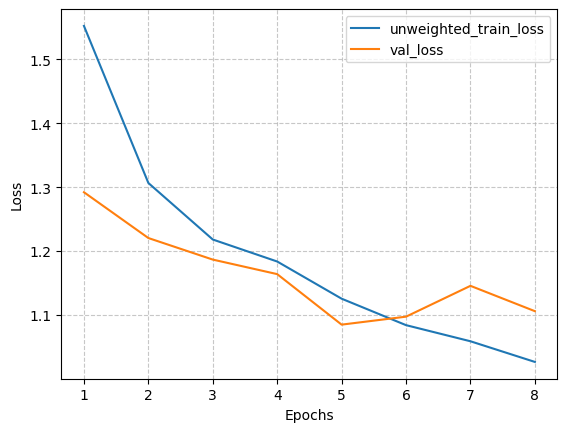

In [16]:
import matplotlib.pyplot as plt
from my_utils.plot_utils import plot_train_val_loss

plot_train_val_loss(history)

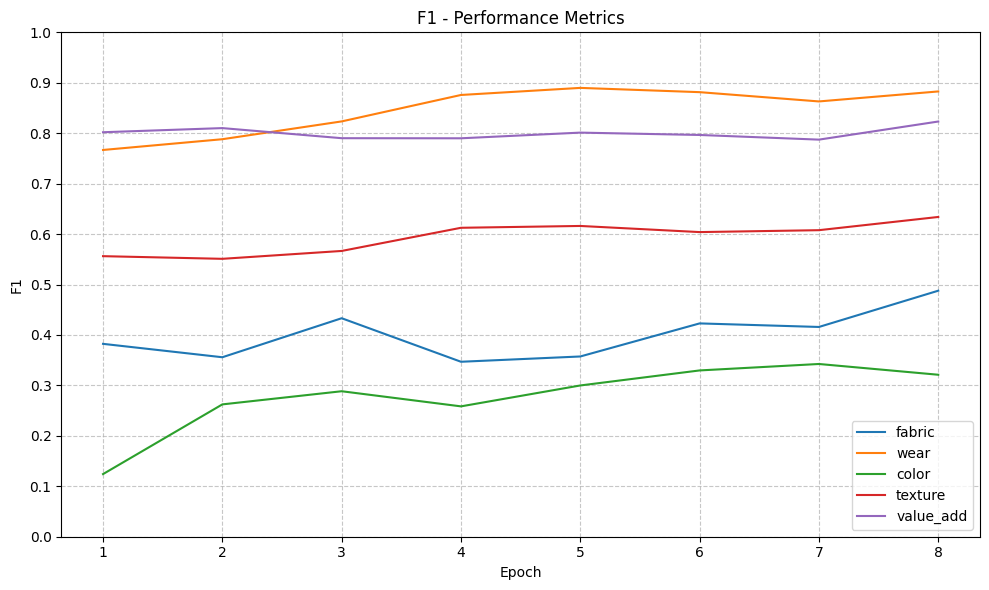

In [17]:
from my_utils.plot_utils import compare_tasks_for_metric

compare_tasks_for_metric(history, 'f1', show_losses=False)

In [18]:
from my_utils.eval_utils import parse_task_metrics

task_metrics, classwise_metrics = parse_task_metrics(history, verbose=True)

pd.DataFrame.from_dict(task_metrics, orient='index').T.round(2)

Best Epoch #: 5


,fabric,wear,color,texture,value_add
f1,0.36,0.89,0.30,0.62,0.80
precision,0.69,0.91,0.70,0.75,0.81
recall,0.24,0.87,0.19,0.52,0.79
accuracy,0.24,0.86,0.03,0.39,0.75


Lets revisit the baseline, and compare against this one. I have refactored code for parsing history to extract task metrics, classwise metrics from previous notebook into utility functions.

In [19]:
from IPython.display import display
from my_utils.eval_utils import load_task_metrics_for_test
import pandas as pd

effnet_metrics, effnet_claswise_metrics = parse_task_metrics(history)
baseline_metrics, baseline_classwise_metrics = load_task_metrics_for_test('../data/model_weights/test_metrics-best_model-resnet18_baseline.pt.json')

print("EfficientNet Performance:")
display(pd.DataFrame.from_dict(effnet_metrics, orient='index').T.round(2))

print("\nBaseline Performance (Resnet 18):")
display(pd.DataFrame.from_dict(baseline_metrics, orient='index').T.round(2))

EfficientNet Performance:


,fabric,wear,color,texture,value_add
f1,0.36,0.89,0.30,0.62,0.80
precision,0.69,0.91,0.70,0.75,0.81
recall,0.24,0.87,0.19,0.52,0.79
accuracy,0.24,0.86,0.03,0.39,0.75



Baseline Performance (Resnet 18):


,fabric,wear,color,texture,value_add
f1,0.48,0.85,0.48,0.58,0.73
precision,0.64,0.90,0.64,0.75,0.75
recall,0.39,0.80,0.39,0.48,0.70
accuracy,0.38,0.79,0.09,0.35,0.65


Let's compare the F1 score and Recall side by side

In [21]:
def compare_task_with_baseline(baseline_metrics, model_metrics, metrics=['accuracy', 'f1', 'precision', 'recall'], baseline_model_name ='ResNet18', new_model_name='??'):
	baseline_perf = pd.DataFrame.from_dict(baseline_metrics, orient='index').T
	model_perf = pd.DataFrame.from_dict(model_metrics, orient='index').T

	rows = []

	for metric in metrics:
		for task in baseline_perf.T.index:
			baseline_value = baseline_perf[task][metric]
			model_value = model_perf[task][metric]
			delta = model_value - baseline_value

			row = {
				'Metric': metric,
				'Task': task,
				f'Baseline ({baseline_model_name})': round(baseline_value, 2),
				f'{new_model_name}': round(model_value, 2),
				'Delta': round(delta, 2)
			}

			rows.append(row)

	comparison_df = pd.DataFrame(rows)

	return comparison_df

compare_task_with_baseline(baseline_metrics, effnet_metrics, metrics=['f1', 'accuracy'], baseline_model_name='ResNet18', new_model_name='EfficientNet B0')


,Metric,Task,Baseline (ResNet18),EfficientNet B0,Delta
0,f1,fabric,0.48,0.36,-0.13
1,f1,wear,0.85,0.89,0.04
2,f1,color,0.48,0.30,-0.18
3,f1,texture,0.58,0.62,0.03
4,f1,value_add,0.73,0.80,0.08
5,accuracy,fabric,0.38,0.24,-0.14
6,accuracy,wear,0.79,0.86,0.06
7,accuracy,color,0.09,0.03,-0.06
8,accuracy,texture,0.35,0.39,0.05
9,accuracy,value_add,0.65,0.75,0.10


So F1 score improved for Wear, Texture and Value addition, but slightly decreased for rest. The accuracy of Color classification has further decreased.

Let's also check the classwise metrics for colors again to see if it improved compared to baseline, for some of the poorly performing classes.

In [22]:
from my_utils.eval_utils import get_classwise_metric

color_f1 = get_classwise_metric(effnet_claswise_metrics, 'color', 'f1')
color_support = get_classwise_metric(effnet_claswise_metrics, 'color', 'support')
color_predicted_support = get_classwise_metric(effnet_claswise_metrics, 'color', 'predicted_support')

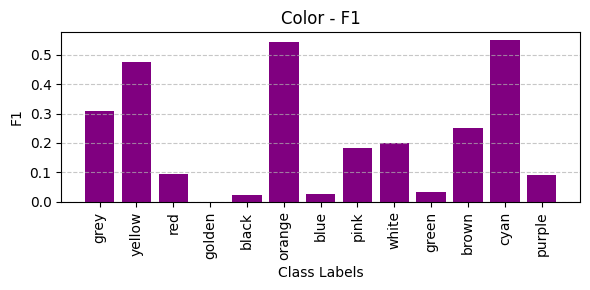

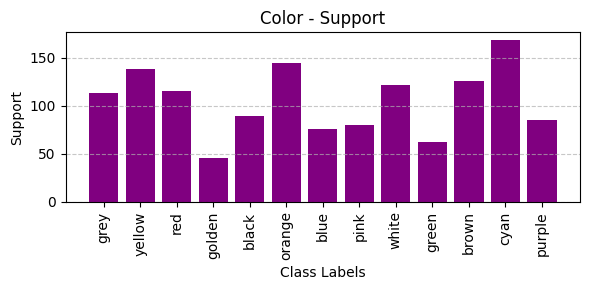

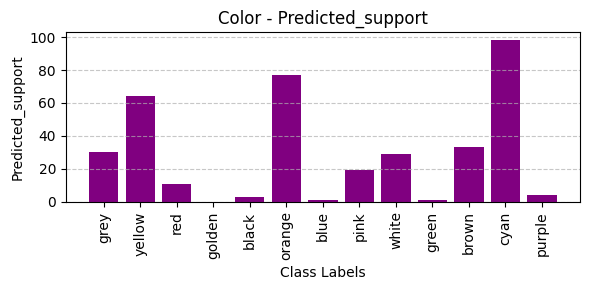

In [23]:
from my_utils.plot_utils import plot_classwise_metric

plot_classwise_metric(color_f1, 'color', 'f1')

plot_classwise_metric(color_support, 'color', 'support')
plot_classwise_metric(color_predicted_support, 'color', 'predicted_support')

Good thing is model did classify some red this time, unlike catastrophically failing to classify any red in the previous baseline run! However, this time it performed ppor on golden and green.

## Additional Experiments

Now let's do a few more experiments using the same EfficientNet backbone, but with different configurations.

### Threshold Variation

In [26]:
model = MTLModelEfficientNet(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
	freeze_backbone=False
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.3,
	use_class_weights=True,
	verbose=False,
	model_name='efficientnet_mtl_th0.3_cw'
)


Epoch 1/10


100%|██████████| 62/62 [00:03<00:00, 17.58it/s]


Train Loss: 15.5273
Val Loss: 1.3184

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 17.23it/s]


Train Loss: 12.4508
Val Loss: 1.2179

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 16.72it/s]


Train Loss: 11.4697
Val Loss: 1.1959

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 17.16it/s]


Train Loss: 10.7607
Val Loss: 1.1691

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 17.53it/s]


Train Loss: 10.0939
Val Loss: 1.0969

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 16.52it/s]


Train Loss: 9.6168
Val Loss: 1.1676

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 16.77it/s]


Train Loss: 9.2290
Val Loss: 1.1435

Epoch 8/10


100%|██████████| 62/62 [00:04<00:00, 15.33it/s]


Train Loss: 8.6735
Val Loss: 1.1691
Early stopping triggered.


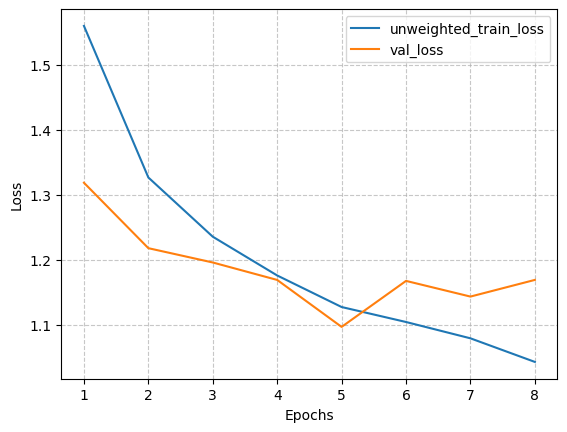

In [27]:
plot_train_val_loss(history)

In [28]:
task_metrics, classwise_metrics = parse_task_metrics(history, verbose=True)

pd.DataFrame.from_dict(task_metrics, orient='index').T.round(2)

Best Epoch #: 5


,fabric,wear,color,texture,value_add
f1,0.54,0.88,0.47,0.62,0.81
precision,0.47,0.85,0.42,0.64,0.76
recall,0.64,0.92,0.52,0.60,0.86
accuracy,0.34,0.84,0.02,0.37,0.72


In [32]:
baseline_metrics, baseline_classwise_metrics = load_task_metrics_for_test('../data/model_weights/test_metrics-best_model-resnet18_baseline.pt.json')

compare_task_with_baseline(baseline_metrics, task_metrics, metrics=['f1', 'accuracy'], baseline_model_name='ResNet18', new_model_name='EfficientNet B0 (Threshold=0.3)')

,Metric,Task,Baseline (ResNet18),EfficientNet B0 (Threshold=0.3),Delta
0,f1,fabric,0.48,0.54,0.05
1,f1,wear,0.85,0.88,0.04
2,f1,color,0.48,0.47,-0.01
3,f1,texture,0.58,0.62,0.03
4,f1,value_add,0.73,0.81,0.08
5,accuracy,fabric,0.38,0.34,-0.03
6,accuracy,wear,0.79,0.84,0.04
7,accuracy,color,0.09,0.02,-0.07
8,accuracy,texture,0.35,0.37,0.02
9,accuracy,value_add,0.65,0.72,0.08


So setting threshold to 0.3 seem to improve F1 and accuracy for most of the tasks, by a very small margin though.

## Conclusion

This experiment with EfficientNet B0 did not yield any significant improvement over the previous baseline, even though F1 score went up by a little bit for few tasks. The model is still struggling with Color classification, and the overall performance is not satisfactory.

In next experiments, I will take some of the techniques from this experiment and apply to a more complex ResNet and EfficientNet models and see how they perform.